In [1]:
# %matplotlib ipympl
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import torch
import torch.nn.functional as F
import os
import psutil
from utils.preprocess import *
from matplotlib.patches import Rectangle

# Get available memory
available_memory = psutil.virtual_memory().available

# Assuming np.float64
element_size = np.dtype(np.float64).itemsize

# Calculate max array size
max_array_size = available_memory / element_size

print(f"Maximum array size (np.float64): {max_array_size} elements")

Maximum array size (np.float64): 25101459456.0 elements


In [2]:
# Data loading Version 2 - toy data previously
data_root = '/scratch/bbsg/hangy6/RLS/data'
# patient_dir = f'{data_root}/patient01-08-27-2023'
# patient_dir = f'{data_root}/patient03-12-12-2023'
# patient_dir = f'{data_root}/patient04-12-14-2023'
# patient_dir = f'{data_root}/patient05-02-15-2024'
# patient_dir = f'{data_root}/patient06-02-17-2024'
# patient_dir = f'{data_root}/patient07-02-24-2024'
# patient_dir = f'{data_root}/patient08-02-29-2024'
# patient_dir = f'{data_root}/patient09-03-01-2024'
# patient_dir = f'{data_root}/patient10-03-14-2024'
patient_dir = f'{data_root}/patient11-03-15-2024'
# patient_dir = f'{data_root}/patient13-03-31-2024'
# patient_dir = f'{data_root}/patient14-04-03-2024'

print(f'Memory available before loading data: {psutil.virtual_memory().available}')
try:
    del matrices, timestamps, data
except:
    pass

window_size = 156
data_file = os.path.join(patient_dir, 'raw_pressure_data.npy')
timestamps_file = os.path.join(patient_dir, 'raw_timestamps.npy')
if os.path.exists(data_file) and os.path.exists(timestamps_file):
    print('load existing pressure data...')
    matrices = np.load(data_file).astype(np.float32)
    timestamps = np.load(timestamps_file)
    print(f'successfully loaded pressure data from {data_file} and timestamps from {timestamps_file}')
else:
    print('Generating pressure data from raw json file...')
    pressure_data = load_json(os.path.join(patient_dir, 'raw_data.json'))
    matrices, timestamps = get_pressure_matrices(pressure_data)
    np.save(data_file, np.array(matrices))
    np.save(timestamps_file, np.array(timestamps))
    print('Successfully saved pressure data and timestamps')

Memory available before loading data: 200823971840
Generating pressure data from raw json file...
594890 data records loaded from /scratch/bbsg/hangy6/RLS/data/patient11-03-15-2024/raw_data.json!
Successfully saved pressure data and timestamps


In [10]:
data = get_data_chunks(matrices, timestamps, window_size)
print(f'Memory available after loading data: {psutil.virtual_memory().available}')
data.shape

Memory available after loading data: 191176278016


(3813, 156, 16, 16)

In [18]:
timestamps[-1]

'2024-03-16T05:38:50.3537461-05:00'

In [16]:
mask = data.sum(axis=(1,2,3)) == 0
chunked_zero_timestamps = timestamps[::156][:-1][mask]
chunked_zero_timestamps

array(['2024-03-15T21:31:30.9614573-05:00',
       '2024-03-15T21:31:38.910506-05:00',
       '2024-03-15T21:31:54.6642456-05:00',
       '2024-03-15T21:32:18.2760267-05:00',
       '2024-03-15T21:32:26.1212038-05:00',
       '2024-03-15T21:32:33.9763935-05:00',
       '2024-03-15T21:32:41.8042248-05:00',
       '2024-03-15T21:32:49.6501514-05:00',
       '2024-03-15T21:32:57.526-05:00',
       '2024-03-15T21:33:05.3820179-05:00',
       '2024-03-15T21:33:13.2380179-05:00',
       '2024-03-15T21:33:21.0980506-05:00',
       '2024-03-15T21:33:28.9781317-05:00',
       '2024-03-15T21:33:44.7377712-05:00',
       '2024-03-15T21:33:52.577583-05:00',
       '2024-03-15T21:34:00.4447895-05:00',
       '2024-03-15T21:34:08.312448-05:00',
       '2024-03-15T21:34:23.9826099-05:00',
       '2024-03-15T21:34:55.4891842-05:00',
       '2024-03-15T21:35:11.1455103-05:00',
       '2024-03-15T21:35:19.023642-05:00',
       '2024-03-15T21:35:26.827741-05:00',
       '2024-03-15T21:35:34.6831485-05:00

In [4]:
mask = matrices.sum(axis=(1, 2)) == 0
zero_timestamps = timestamps[mask]
zero_timestamps.shape

(130083,)

In [5]:
zero_timestamps

array(['2024-03-31T21:03:41.6600583-05:00',
       '2024-03-31T21:05:12.9246018-05:00',
       '2024-03-31T21:05:13.0202243-05:00', ...,
       '2024-04-01T05:48:16.6415001-05:00',
       '2024-04-01T05:48:16.6893362-05:00',
       '2024-04-01T05:48:16.7362174-05:00'], dtype='<U33')

In [19]:
zero_timestamps[-10:]

array(['2024-03-16T04:32:09.3765622-05:00',
       '2024-03-16T04:32:09.431152-05:00',
       '2024-03-16T04:32:09.4709756-05:00',
       '2024-03-16T05:03:24.0878039-05:00',
       '2024-03-16T05:03:24.1352289-05:00',
       '2024-03-16T05:03:24.197729-05:00',
       '2024-03-16T05:03:24.2464623-05:00',
       '2024-03-16T05:04:46.3212504-05:00',
       '2024-03-16T05:04:46.3669298-05:00',
       '2024-03-16T05:04:46.4147616-05:00'], dtype='<U33')

In [8]:
# bar = data.sum(axis=(1,2,3)) != 0
# np.save(f'{patient_dir}/win{window_size}_data_bar.npy', bar)
# plt.plot(np.arange(len(bar)), bar)
# cosine_matrix = cosine_similarity(data, data)
# plt.imshow(cosine_matrix)
# plt.colorbar()
# plt.savefig(f'{path}/win{window_size}_full_data_cosine_similarity.png')

In [9]:
def plot_bar(bars):
    bar_lens = [len(bar) for bar in bars]
    print(max(bar_lens))
    plt.xlim(0, max(bar_lens))
    plt.ylim(0, len(bars) * 0.2)
    for i in range(max(bar_lens)):
        for j in range(len(bars)):
            if len(bars[j]) <= i:
                continue
            color = 'red' if bars[j][i] else 'black'
            rect = Rectangle((i, 0.2 * j), 1, 0.1, edgecolor=color, facecolor=color, linewidth=0.1)
            plt.gca().add_patch(rect)
        

4078


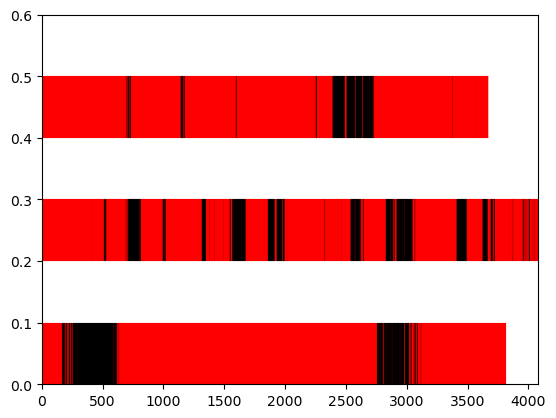

In [12]:
bar_filename = 'win156_data_bar.npy'
bars = [np.load(f'{data_root}/patient11-03-15-2024/' + bar_filename),\
        np.load(f'{data_root}/patient13-03-31-2024/' + bar_filename),\
        np.load(f'{data_root}/patient14-04-03-2024/' + bar_filename)]
# bars = [np.load(os.path.join(patient_dir, bar_filename))]
plot_bar(bars)
plt.savefig('sanity_check.png')